In [1]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import ReLU, Add, Flatten
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# code to deal with tensorflow GPU errors
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Defining arguments

In [3]:
args = {
    'lr':0.001,
    'epochs':100,
    'img_size':32,
    'n_classes':100,
    'batch_size':64,
    'n':2
}

Loading data

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [5]:
def get_mean_std(images):
    images = images.astype(np.float32)
    mean_vals = ()
    std_vals = ()
    for i in range(images.shape[-1]):
        mean_vals += (np.mean(images[:, :, :, i]),)
        std_vals += (np.std(images[:, :, :, i]),)
    return mean_vals, std_vals

Normalizing data

In [6]:
mean_vals, std_vals = get_mean_std(x_train)
print(mean_vals)
print(std_vals)

(129.30428, 124.07023, 112.43411)
(68.17024, 65.391785, 70.4184)


In [7]:
def normalize(images, mean_vals, std_vals):
    images = images.astype(np.float32)
    for i in range(images.shape[-1]):
        images[:, :, :, i] = (images[:, :, :, i] - mean_vals[i])/std_vals[i]
    return images


In [8]:
x_train = normalize(x_train, mean_vals, std_vals)
x_test = normalize(x_test, mean_vals, std_vals)
print(x_test.max(), x_test.min())

2.0245545 -1.8973366


Data augmentation

In [9]:
def augment(image, label):
    img_size = image.shape[0]
    image = tf.image.resize_with_crop_or_pad(image, img_size + 4, img_size + 4)
    image = tf.image.random_crop(image, size=(img_size, img_size, 3))
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_flip_left_right(image)

    return image, label

Dividing into train, validation

In [10]:
val_frac = 0.2
perm_ids = np.random.permutation(x_train.shape[0])
val_ids = perm_ids[:int(val_frac*x_train.shape[0])]
train_ids = perm_ids[int(val_frac*x_train.shape[0]):]
x_val, y_val = x_train[val_ids], y_train[val_ids]
x_train, y_train = x_train[train_ids], y_train[train_ids]

Creating dataset objects

In [11]:
train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                           .map(augment, num_parallel_calls = tf.data.AUTOTUNE)
                           .shuffle(x_train.shape[0])
                           .batch(args['batch_size'])
                           )
val_ds = (tf.data.Dataset.from_tensor_slices((x_val, y_val))
                         .batch(args['batch_size'])
                         )
test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                          .batch(args['batch_size'])
                          )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


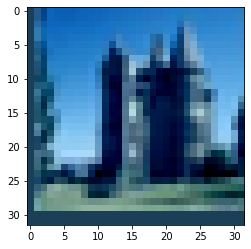

In [12]:
# testing if data loaders work properly
for images, targets in train_ds.take(1):
    for i in range(1):
        plt.imshow(images[i])

Resnet model (copied from https://github.com/GoogleCloudPlatform/keras-idiomatic-programmer/blob/master/zoo/resnet/resnet_cifar10.py)

In [13]:
def stem(inputs):
    ''' Construct the Stem Convolutional Group 
        inputs : the input vector
    '''
    x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
def learner(x, n_blocks):
    """ Construct the Learner
        x          : input to the learner
        n_blocks   : number of blocks in a group
    """
    # First Residual Block Group of 16 filters (Stage 1)
    # Quadruple (4X) the size of filters to fit the next Residual Group
    x = residual_group(x, 16, n_blocks, strides=(1, 1), n=4)

    # Second Residual Block Group of 64 filters (Stage 2)
    # Double (2X) the size of filters and reduce feature maps by 75% (strides=2) to fit the next Residual Group
    x = residual_group(x, 64, n_blocks, n=2)

    # Third Residual Block Group of 64 filters (Stage 3)
    # Double (2X) the size of filters and reduce feature maps by 75% (strides=2) to fit the next Residual Group
    x = residual_group(x, 128, n_blocks, n=2)
    return x

def residual_group(x, n_filters, n_blocks, strides=(2, 2), n=2):
    """ Construct a Residual Group
        x         : input into the group
        n_filters : number of filters for the group
        n_blocks  : number of residual blocks with identity link
        strides   : whether the projection block is a strided convolution
        n         : multiplier for the number of filters out
    """
    # Double the size of filters to fit the first Residual Group
    x = projection_block(x, n_filters, strides=strides, n=n)

    # Identity residual blocks
    for _ in range(n_blocks):
        x = identity_block(x, n_filters, n)
    return x
    
def identity_block(x, n_filters, n=2):
    """ Construct a Bottleneck Residual Block of Convolutions with Identity Shortcut
        x        : input into the block
        n_filters: number of filters
        n        : multiplier for filters out
    """
    # Save input vector (feature maps) for the identity link
    shortcut = x
    
    ## Construct the 1x1, 3x3, 1x1 residual block (fig 3c)

    # Dimensionality reduction
    x = Conv2D(n_filters, (1, 1), strides=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Bottleneck layer
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Dimensionality restoration - increase the number of output filters by 2X or 4X
    x = Conv2D(n_filters * n, (1, 1), strides=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Add the identity link (input) to the output of the residual block
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def projection_block(x, n_filters, strides=(2,2), n=2):
    """ Construct Bottleneck Residual Block with Projection Shortcut
        Increase the number of filters by 2X (or 4X on first stage)
        x        : input into the block
        n_filters: number of filters
        strides  : whether the first convolution is strided
        n        : multiplier for number of filters out
    """
    # Construct the projection shortcut
    # Increase filters by 2X (or 4X) to match shape when added to output of block
    shortcut = Conv2D(n_filters * n, (1, 1), strides=strides, kernel_initializer='he_normal')(x)

    ## Construct the 1x1, 3x3, 1x1 convolution block

    # Dimensionality reduction
    x = Conv2D(n_filters, (1, 1), strides=(1,1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Bottleneck layer - feature pooling when strides=(2, 2)
    x = Conv2D(n_filters, (3, 3), strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)  
    
    # Dimensionality restoration - increase the number of filters by 2X (or 4X)
    x = Conv2D(n_filters * n, (1, 1), strides=(1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Add the projection shortcut to the output of the residual block
    x = Add()([shortcut, x])
    x = ReLU()(x)
    return x
    
def classifier(x, n_classes):
    ''' Construct the Classifier
        x         : input into the classifier
        n_classes : number of classes
    '''
    # Pool the feature maps after the end of all the residual blocks
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D(pool_size=8)(x)
    
    # Flatten into 1D vector
    x = Flatten()(x)

    # Final Dense Outputting Layer 
    outputs = Dense(n_classes, activation='softmax', kernel_initializer='he_normal')(x)
    return outputs

In [14]:
def build_model(args):
    n = args['n']    
    depth =  n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1
    num_classes = args['n_classes']
    input_shape = (args['img_size'], args['img_size'], 3)
    inputs = Input(input_shape)
    x = stem(inputs) 
    x = learner(x, n_blocks)
    outputs = classifier(x, num_classes)
    model = Model(inputs, outputs)
    return model

Compiling model

In [15]:
model = build_model(args)

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10), 
             ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, verbose = 1)]

model.compile(optimizer=Adam(learning_rate=args['lr']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = args['epochs'],
    callbacks = callbacks,
    verbose = 2
)

Epoch 1/100
625/625 - 38s - loss: 4.0975 - accuracy: 0.0742 - val_loss: 4.4766 - val_accuracy: 0.0495 - lr: 0.0010 - 38s/epoch - 61ms/step
Epoch 2/100
625/625 - 23s - loss: 3.5736 - accuracy: 0.1467 - val_loss: 5.1752 - val_accuracy: 0.0486 - lr: 0.0010 - 23s/epoch - 36ms/step
Epoch 3/100
625/625 - 22s - loss: 3.0899 - accuracy: 0.2314 - val_loss: 3.6787 - val_accuracy: 0.1515 - lr: 0.0010 - 22s/epoch - 36ms/step
Epoch 4/100
625/625 - 23s - loss: 2.7435 - accuracy: 0.2973 - val_loss: 3.5987 - val_accuracy: 0.1712 - lr: 0.0010 - 23s/epoch - 36ms/step
Epoch 5/100
625/625 - 22s - loss: 2.4955 - accuracy: 0.3491 - val_loss: 3.4955 - val_accuracy: 0.2004 - lr: 0.0010 - 22s/epoch - 36ms/step
Epoch 6/100
625/625 - 22s - loss: 2.2971 - accuracy: 0.3939 - val_loss: 2.9636 - val_accuracy: 0.2756 - lr: 0.0010 - 22s/epoch - 35ms/step
Epoch 7/100
625/625 - 22s - loss: 2.1470 - accuracy: 0.4265 - val_loss: 3.0976 - val_accuracy: 0.2788 - lr: 0.0010 - 22s/epoch - 35ms/step
Epoch 8/100
625/625 - 22s -

Plotting metrics

Text(0, 0.5, 'Loss')

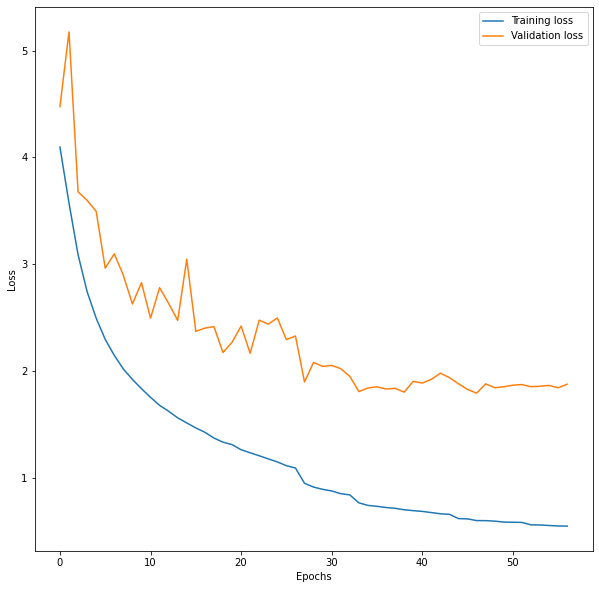

In [18]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

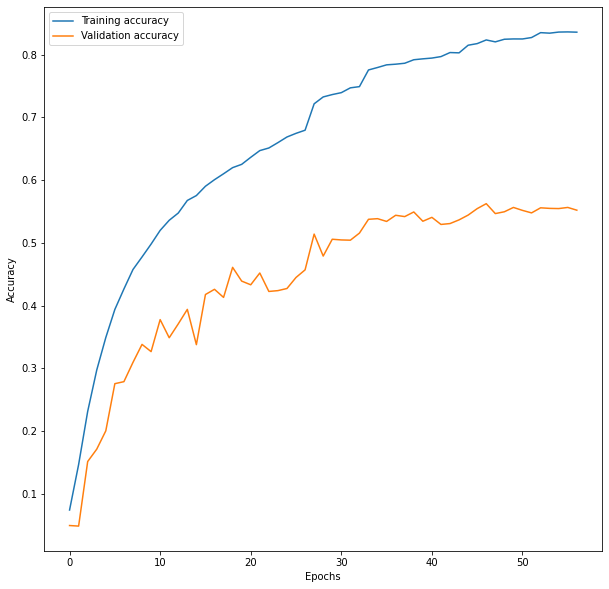

In [19]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Learning rate')

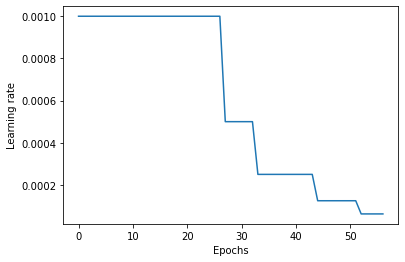

In [20]:
plt.plot(history.history['lr'])
plt.xlabel("Epochs")
plt.ylabel("Learning rate")